# Import

In [1]:
import gensim
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import random as rand
import scipy.spatial
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import numpy as np
from sklearn.neighbors import NearestNeighbors
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import linear_kernel
import enchant
from nltk.corpus import words, stopwords, names
from nltk.stem import WordNetLemmatizer
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.decomposition import PCA
from ebooklib import epub
import ebooklib
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
from sklearn.preprocessing import normalize
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib import cm

nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SherryAi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SherryAi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SherryAi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
ENGLISH_DICT1 = enchant.Dict("en_UK")
ENGLISH_DICT2 = enchant.Dict("en_US")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SherryAi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SherryAi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load functions

In [3]:
def preprocess(paragraph):
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()

    words = gensim.utils.simple_preprocess(paragraph, min_len=3, deacc=True)
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    processed_doc = " ".join(processed_words)
    return processed_doc
def load_list_from_file(file_name):
    try:
        with open(file_name, 'rb') as file:
            lst = pickle.load(file)
        return lst
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# SOM functions

In [4]:
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'cosine')[0][0]
    QE = sumSqDist/len(data)
    return QE

def find_BMU_2(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argpartition(cos_sims, -2, axis=None)[-2], cos_sims.shape)


def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p
def find_BMU(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)

def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM



def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]

def train_SOM(SOM, train_data, learn_rate, radius_sq, lr_decay, radius_decay, epochs, text_data):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    som_versions = []
    error_records = []
    min_error_sum = float('inf')
    best_som = None
    best_errors = None
    neuron_texts = { (i, j): [] for i in range(SOM.shape[0]) for j in range(SOM.shape[1]) }  # Initialize mapping

    for epoch in range(epochs):
        np.random.shuffle(train_data)
        for train_ex, text in zip(train_data, text_data):  # Assuming text_data aligns with train_data
            g, h = find_BMU(SOM, train_ex)
            neuron_texts[(g, h)].append(text)  # Update mapping with text associated with BMU
            SOM = update_weights(SOM, train_ex, learn_rate, radius_sq, (g, h))
        
        QE = calculateQE(SOM, train_data)
        TE = calculateTE(SOM, train_data)
        current_error_sum = QE + TE
        som_versions.append(np.copy(SOM))
        error_records.append((QE, TE))

        if current_error_sum < min_error_sum:
            min_error_sum = current_error_sum
            best_som = np.copy(SOM)
            best_errors = (QE, TE)

        learn_rate = learn_rate_0 * np.exp(-lr_decay * epoch)
        radius_sq = radius_0 * np.exp(-radius_decay * epoch)

    return best_som, best_errors, som_versions, neuron_texts


colors = ["#ffcccb", "#ff5733", "#900c3f", "#571845"]
custom_cmap = LinearSegmentedColormap.from_list("custom_purple", colors, N=256)

def run_and_visualize_som_training(pca_u_matrix, learn_rates, radiuses, m, n, vector_size, epochs, text_data):
    # Initialize random state
    rand = np.random.RandomState(0)
    best_overall_som = None
    best_overall_error = float('inf')

    # Prepare the plot
    fig, axes = plt.subplots(nrows=len(learn_rates), ncols=len(radiuses), figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})
    colors = ["#ffcccb", "#ff5733", "#900c3f", "#571845"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_purple", colors, N=256)
    
    idx = 0
    for learn_rate in learn_rates:
        for radius in radiuses:
            SOM = rand.uniform(0, 1, (m, n, vector_size))
            # Train the SOM with text data
            best_som, errors, som_versions, neuron_texts = train_SOM(SOM, pca_u_matrix, learn_rate, radius**2, 0.1, 0.1, epochs, text_data)

            if errors[0] + errors[1] < best_overall_error:
                best_overall_error = errors[0] + errors[1]
                best_overall_som = best_som

            final_som = som_versions[-1]
            u_matrix_values = u_matrix(final_som)  # Generate the U-matrix
            ax = axes[idx // len(radiuses)][idx % len(radiuses)]
            im = ax.imshow(u_matrix_values, cmap=custom_cmap, aspect='equal')
            QE, TE = calculateQE(final_som, pca_u_matrix), calculateTE(final_som, pca_u_matrix)
            ax.set_title(f'LR={learn_rate}, R^2={radius**2}\nQE={QE:.4f}, TE={TE:.4f}')
            idx += 1

    # Add color bar and finalize layout
    plt.tight_layout()
    cbar = plt.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal')
    cbar.set_label('Distance')
    plt.show()

    return best_overall_som, best_overall_error


def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += cosine(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += cosine(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values
def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([normalP], [c])[0][0] for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM
def normalise_2(train):
    min_d = np.min(train, axis=0)
    max_d = np.max(train, axis=0)
    normalised_train = (train - min_d) / (max_d - min_d)
    return normalised_train
def find_closest_cos(data, v):
    cos_dist = cosine_similarity(data, [v])
    return np.argmax(cos_dist)

# Visualization functions

In [5]:
def visualize_epochs_som(som_versions, epochs, file_name_base):
    """ Visualizes SOMs at each epoch directly in Jupyter Notebook without saving to files. """
    for epoch, som in enumerate(som_versions):
        plt.figure(figsize=(8, 8))
        u_matrix_values = u_matrix(som)  # Ensure that 'u_matrix' is called with the correct SOM state
        plt.imshow(u_matrix_values, cmap=custom_cmap, aspect='equal')
        plt.title(f'U-Matrix at Epoch {epoch + 1}')
        plt.colorbar(label='Distance')
        plt.xticks([])
        plt.yticks([])

        # Show the plot in Jupyter Notebook
        plt.show()        
    
def visualize_som_with_words(SOM, pca_u_matrix, words_list, u_matrix_values, file_name, dpi=300):
    neuron_word_mapping = {}
    for i in range(SOM.shape[0]):
        for j in range(SOM.shape[1]):
            neuron_word_mapping[(i, j)] = []

    for word, vector in zip(words_list, pca_u_matrix):
        best_matching_unit = find_BMU(SOM, vector)
        if best_matching_unit not in neuron_word_mapping:
            neuron_word_mapping[best_matching_unit] = []
        neuron_word_mapping[best_matching_unit].append(word)

    # Increase the figure size and dpi for better clarity
    plt.figure(figsize=(40, 40), dpi=dpi)  # Adjusting figsize and dpi here
    im = plt.imshow(u_matrix_values, cmap=custom_cmap, aspect='auto')
    plt.colorbar(im, shrink=0.95, label='Distance')

    for (i, j), words in neuron_word_mapping.items():
        text = '\n'.join(words)
        plt.text(j, i, text, ha='center', va='center', color='black', fontsize=12)  # Adjust fontsize if needed

    plt.xticks([])
    plt.yticks([])

    # Show the plot in Jupyter Notebook
    plt.show()

    # Save the figure with high resolution
    plt.savefig(file_name, dpi=dpi, bbox_inches='tight')  # Save the figure with high resolution
    plt.close()  # Close the figure to free up memory

# Search functions

In [6]:
def preprocess_text(text):
    """ Tokenizes, removes stopwords, and lemmatizes the input text. """
    tokens = word_tokenize(text.lower())
    tokens = [WordNetLemmatizer().lemmatize(token) for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    return " ".join(tokens)

def vectorize_and_transform_text(input_text, word2vec_model, pca):
    # Tokenize and vectorize the input text using Word2Vec
    words = input_text.split()  # Simple split; consider more complex preprocessing
    word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]

    # If no words found in the model, handle this case
    if not word_vectors:
        return np.zeros(pca.n_components_)

    # Average the vectors (or another method, like sum)
    average_vector = np.mean(word_vectors, axis=0).reshape(1, -1)
    
    # Apply PCA transformation
    transformed_vector = pca.transform(average_vector)
    
    return transformed_vector

def activate_and_visualize_SOM(SOM, input_vector, textual_content_mapping, title="SOM Activation"):
    # Ensure the input vector is properly shaped and normalized
    norm_input_vector = input_vector / np.linalg.norm(input_vector) if np.linalg.norm(input_vector) > 0 else input_vector
    
    # Reshape and normalize the SOM for cosine similarity calculation
    norm_SOM = SOM.reshape(-1, SOM.shape[-1])
    norm_SOM = norm_SOM / np.linalg.norm(norm_SOM, axis=1, keepdims=True)
    
    # Calculate activation map
    activation_map = cosine_similarity(norm_input_vector, norm_SOM).reshape(SOM.shape[0], SOM.shape[1])
    BMU_index = np.unravel_index(np.argmax(activation_map), activation_map.shape)
    
    # Visualization of the activation map
    plt.figure(figsize=(10, 8))
    plt.imshow(activation_map, cmap=custom_cmap, interpolation='nearest')
    plt.colorbar(label='Activation Level')
    plt.title(title)
    plt.scatter([BMU_index[1]], [BMU_index[0]], color='red', label='BMU')
    plt.legend()
    plt.show()
    
    # Return the BMU index and its content (text instead of vector)
    BMU_text_content = textual_content_mapping[BMU_index] if BMU_index in textual_content_mapping else "No text content available"
    
    return BMU_index, BMU_text_content

# Load and prepare

In [7]:
# Load data
MAGA = load_list_from_file(r"C:\Users\SherryAi\MAGA.pkl")
texts = [preprocess(text) for text in MAGA]
joined_text = " ".join(texts)

# Load Word2Vec model
model_path = r"E:\sp\GoogleNews-vectors-negative300.bin.gz"
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Create TF-IDF model
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

# Identify the top 1000 high-frequency words
high_frequency_1000_index = tfidf_matrix.toarray()[0].argsort()[-1000:]
words_list = [feature_names[i] for i in high_frequency_1000_index]

# Generate word vectors for these high-frequency words
word_vectors = [model[word] for word in words_list if word in model]
word_vectors_matrix = np.array(word_vectors)

# PCA to reduce dimensionality
pca = PCA(n_components=4)
pca_u_matrix = pca.fit_transform(word_vectors_matrix)
pca_u_matrix = normalize(pca_u_matrix, norm='l2')

# Visualize

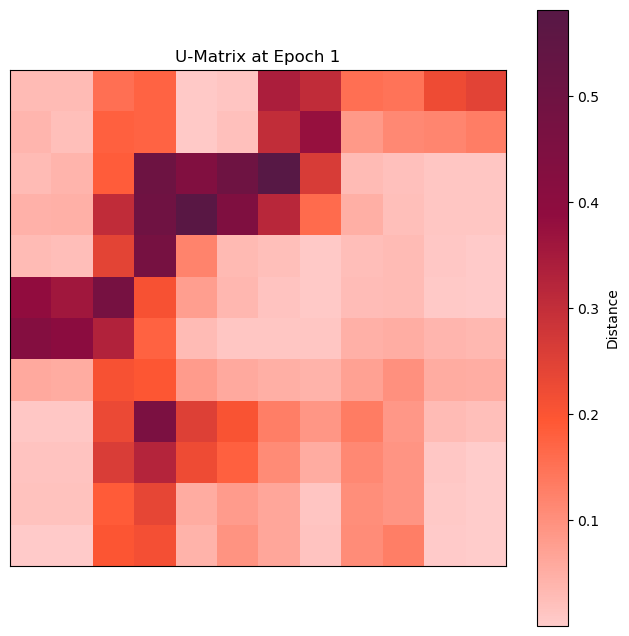

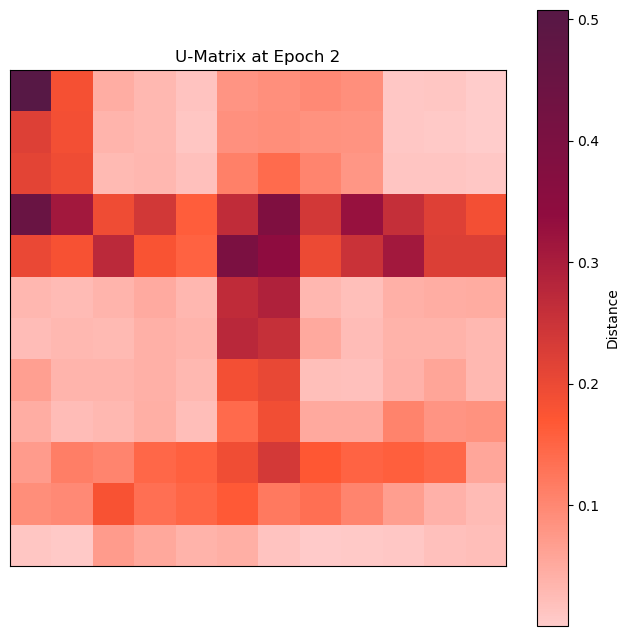

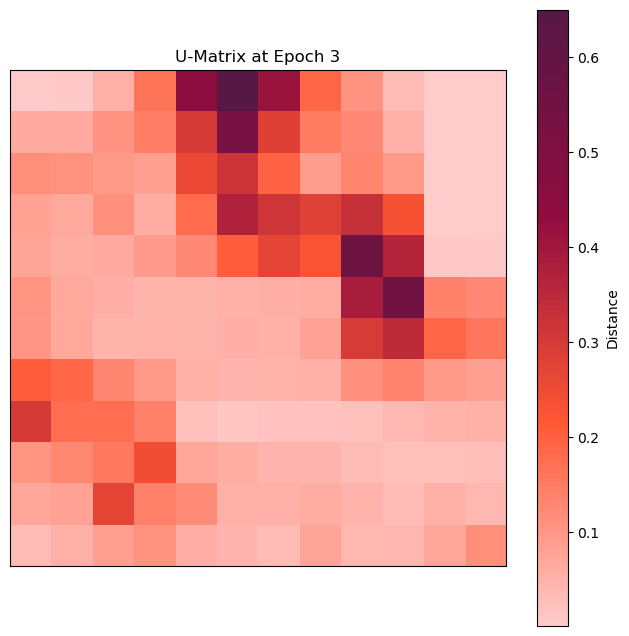

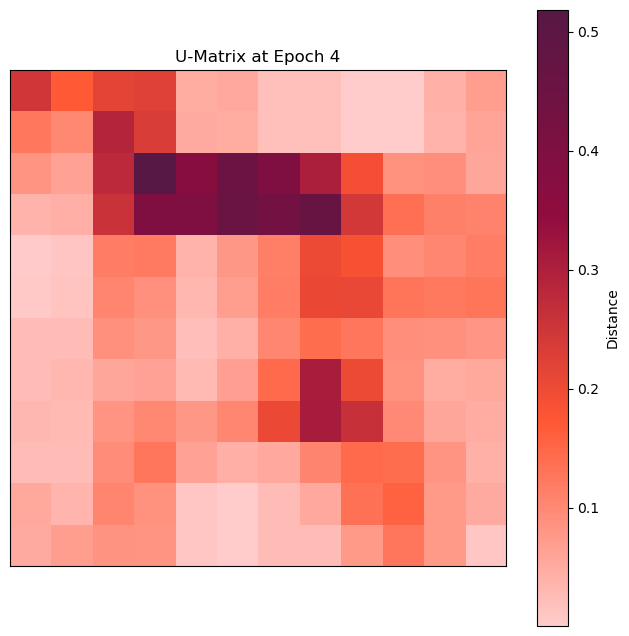

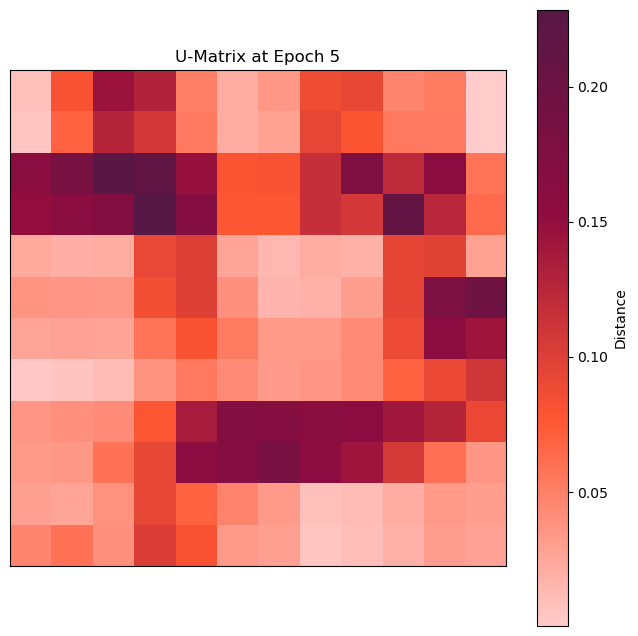

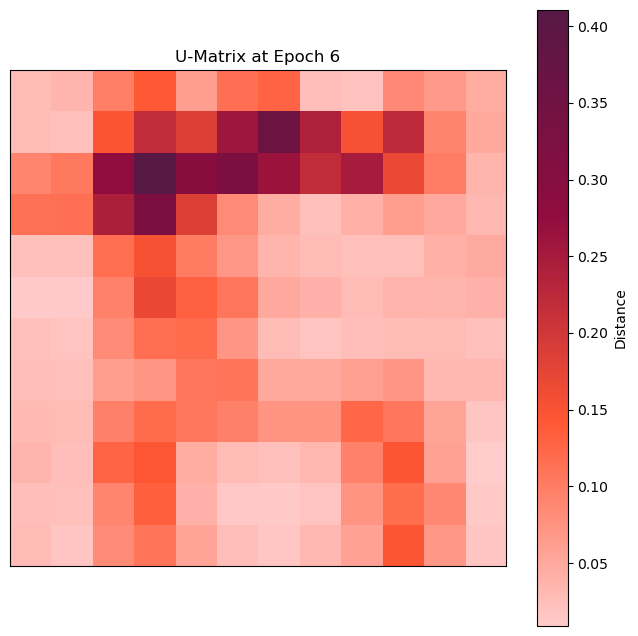

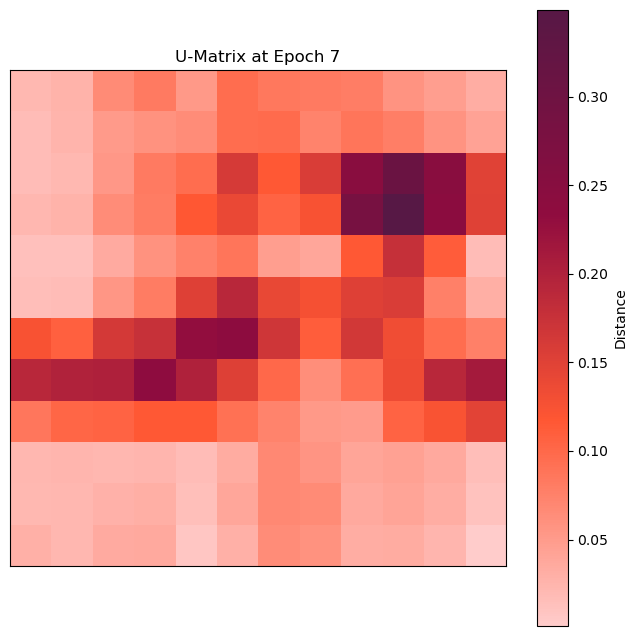

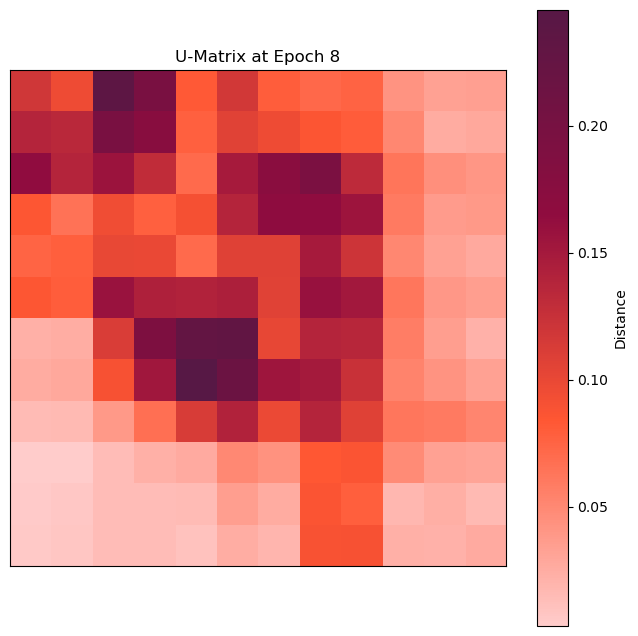

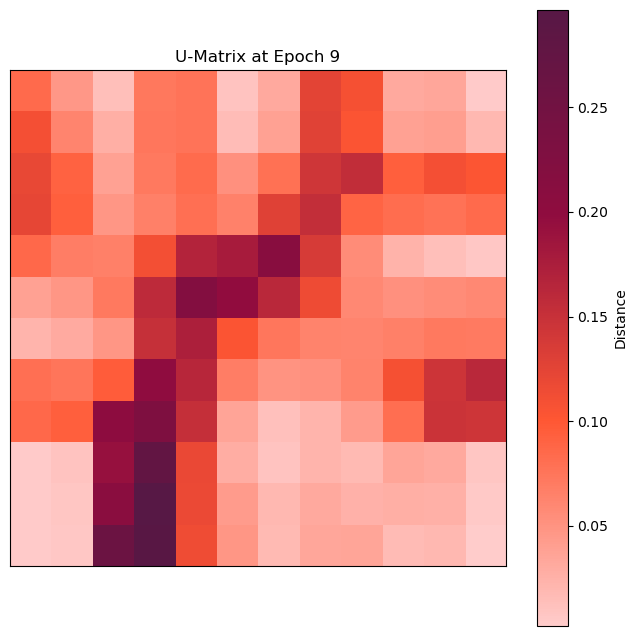

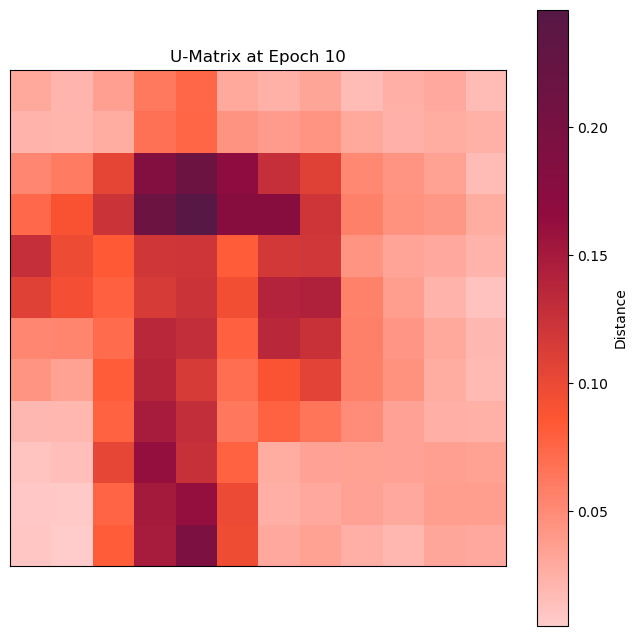

In [8]:
learn_rate = 0.5
radius = 5
epochs = 10
SOM = np.random.rand(12, 12, 4) 
train_data = pca_u_matrix  

best_som, best_errors, som_versions, neuron_texts = train_SOM(SOM, train_data, learn_rate, radius**2, 0.1, 0.1, epochs, texts)

visualize_epochs_som(som_versions, epochs, 'SOM_Visualization')

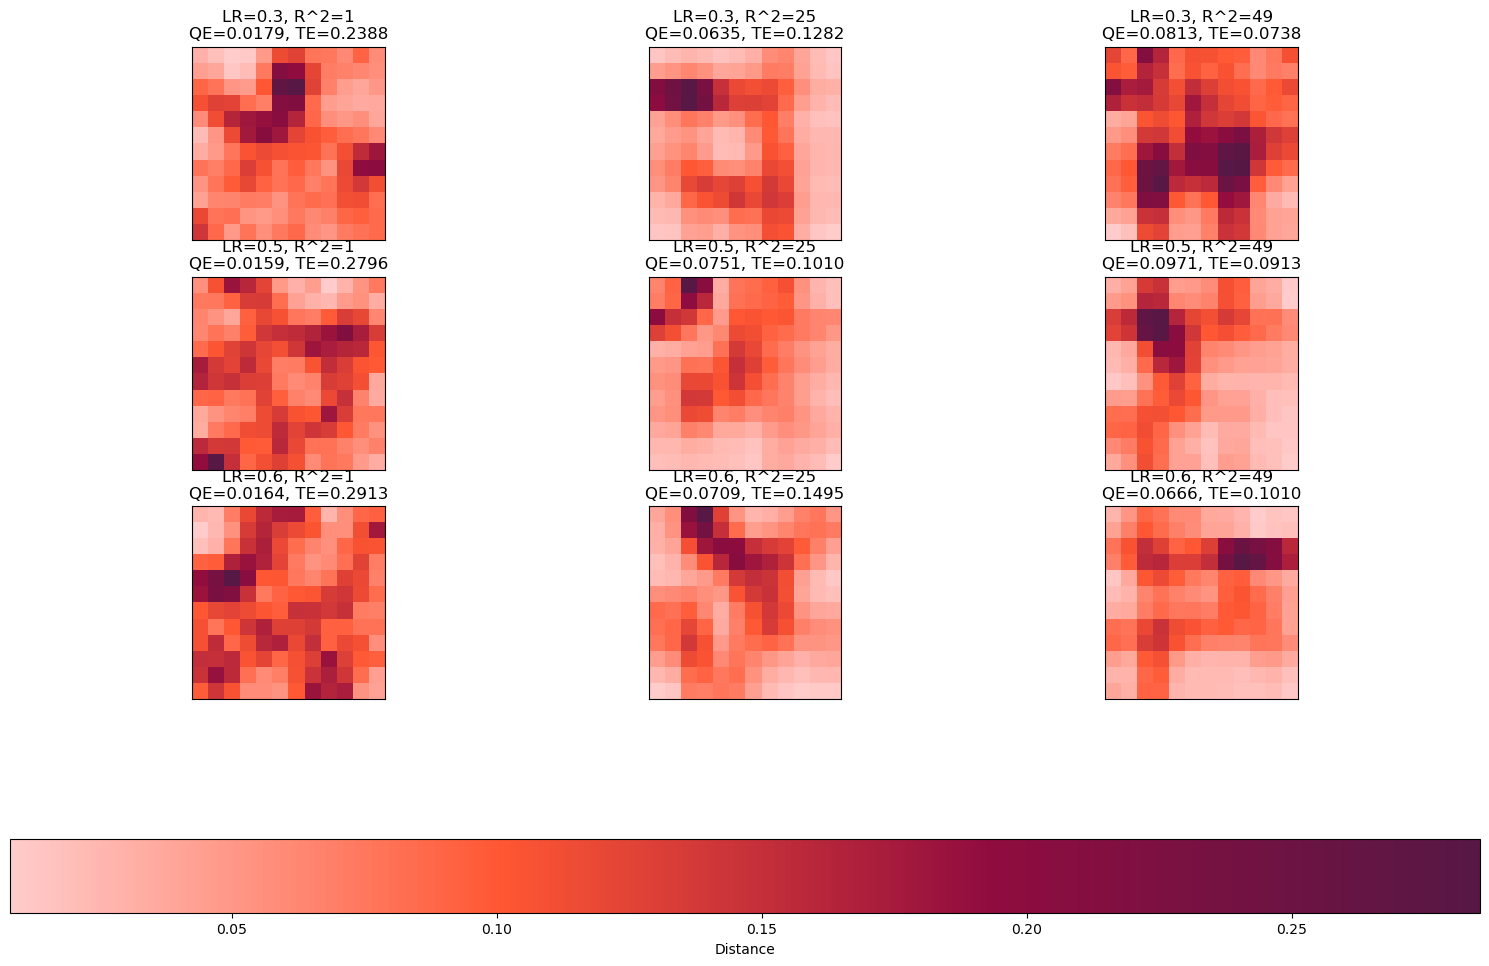

In [9]:
best_overall_som, best_overall_error = run_and_visualize_som_training(pca_u_matrix, [0.3, 0.5, 0.6], [1, 5, 7], 12, 12, 4, 20, texts)

In [10]:
u_matrix_values = u_matrix(best_overall_som)
visualize_som_with_words(best_overall_som, pca_u_matrix, words_list, u_matrix_values, 'SOM_Visualization.png')

# Search

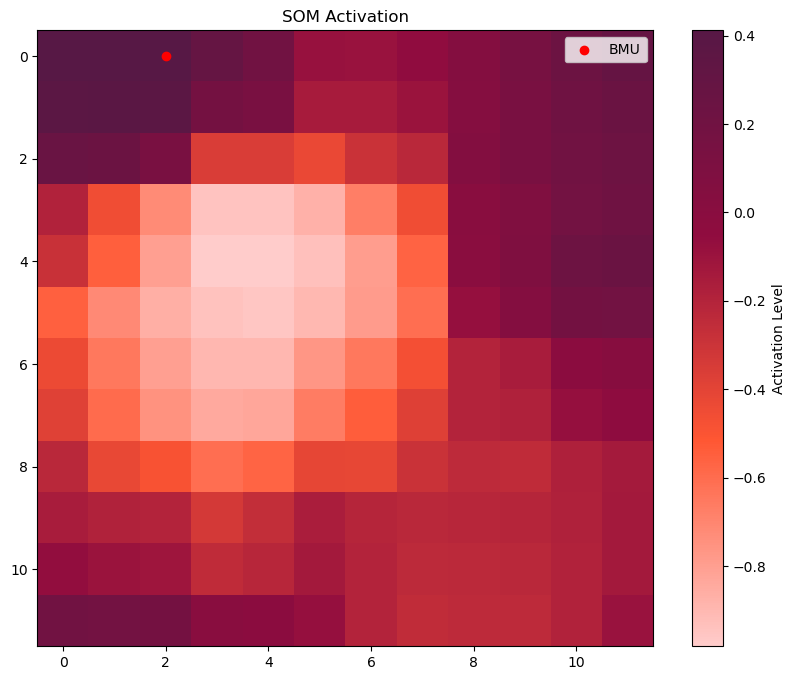

BMU Index: (0, 2)
BMU Content: skinny dip sea night belonging get robbed see advice maga guide http magalufevents com magaluf guide, absentee voting tomorrow virginia also phone bank home tweet work teamtrump trumptrain maga, magaluf hottest new event label naughtytherapy kmedication magaluf maga maga, carly endorsing cruz newsworthy fat kid endorsing cake maga, anita conant speak heard stand anita vote trump trump maga http bit snsgup, maga donald trump fought include jew black palm beach golf course http bit mrqa, lovely picture pastor god bless hope wonderful easter family maga, trump burlington vermont teamtrump teamdonald trumpwinning maga woman trump trumpvoter woman trump, ted going get schlonged maga trump http twitter com joshhollingsw status, want speak front thousand trump supporter someday speak front thousand leatherwood supporter maga, conservative donald trump http youtube com watch trumpac amykremer imwithtrump americafirst, wow look trump take iowa rest country trump f

In [11]:
# Train your SOM and receive the mapping of texts to each neuron
best_som, best_errors, som_versions, neuron_texts = train_SOM(SOM, train_data, learn_rate, radius**2, 0.1, 0.1, epochs, texts)

# Create textual content mapping from neuron_texts
textual_content_mapping = {}
for (i, j), texts in neuron_texts.items():
    textual_content_mapping[(i, j)] = ", ".join(texts) if texts else "No associated text"

# Prepare input text and transform it using previously defined vectorization and PCA transformation
input_text = "BLACK LIVES MATTER Leader Arrested On Charges Of CHILD TRAFFICKING http://po.st/BUnu8M #TrumpsterWarriors #MAGA"
input_vector = vectorize_and_transform_text(input_text, model, pca)

# Use the trained SOM and the input vector to find BMU and display associated text
BMU_index, BMU_content = activate_and_visualize_SOM(best_som, input_vector, textual_content_mapping)
print("BMU Index:", BMU_index)
print("BMU Content:", BMU_content)


# PCA on all cells

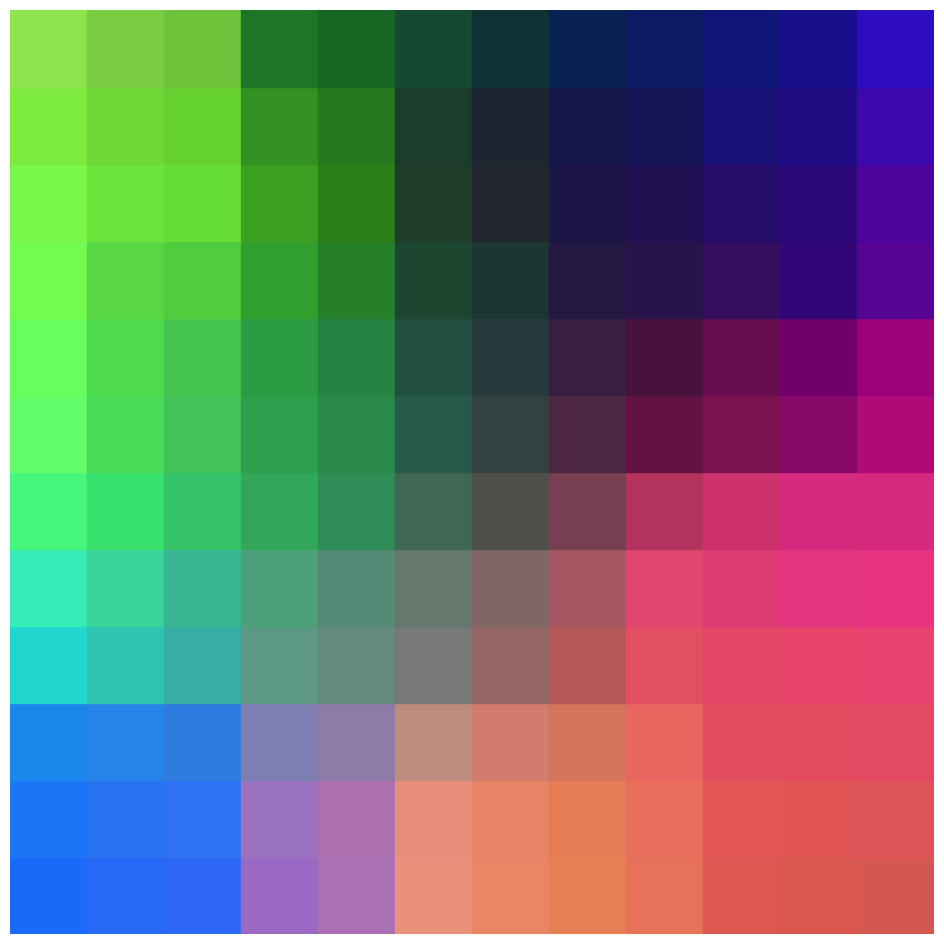

In [12]:
# Assume loaded_text_som_model is your trained SOM model
som_height, som_width, vector_dimension = best_som.shape
num_nodes = som_height * som_width

# Flatten the SOM to apply PCA
flattened_som = best_som.reshape(num_nodes, vector_dimension)

# Apply PCA to reduce dimensions to 3 for RGB visualization
pca = PCA(n_components=3)
colourComponents = pca.fit_transform(flattened_som)

# Normalize PCA components
colourComponents = normalise(colourComponents, colourComponents)

# Convert normalized components to RGB values
rgb_values = (colourComponents * 255).astype(int)

# Prepare a grid for visualization
som_colors = np.zeros((som_height, som_width, 3), dtype=np.uint8)
for i in range(som_height):
    for j in range(som_width):
        node_idx = i * som_width + j
        som_colors[i, j] = rgb_values[node_idx]

# Visualization
fig, ax = plt.subplots(figsize=(som_width, som_height))
for i in range(som_height):
    for j in range(som_width):
        color = som_colors[i, j] / 255.0
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

ax.set_xlim(0, som_width)
ax.set_ylim(0, som_height)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

# PCA on entire training

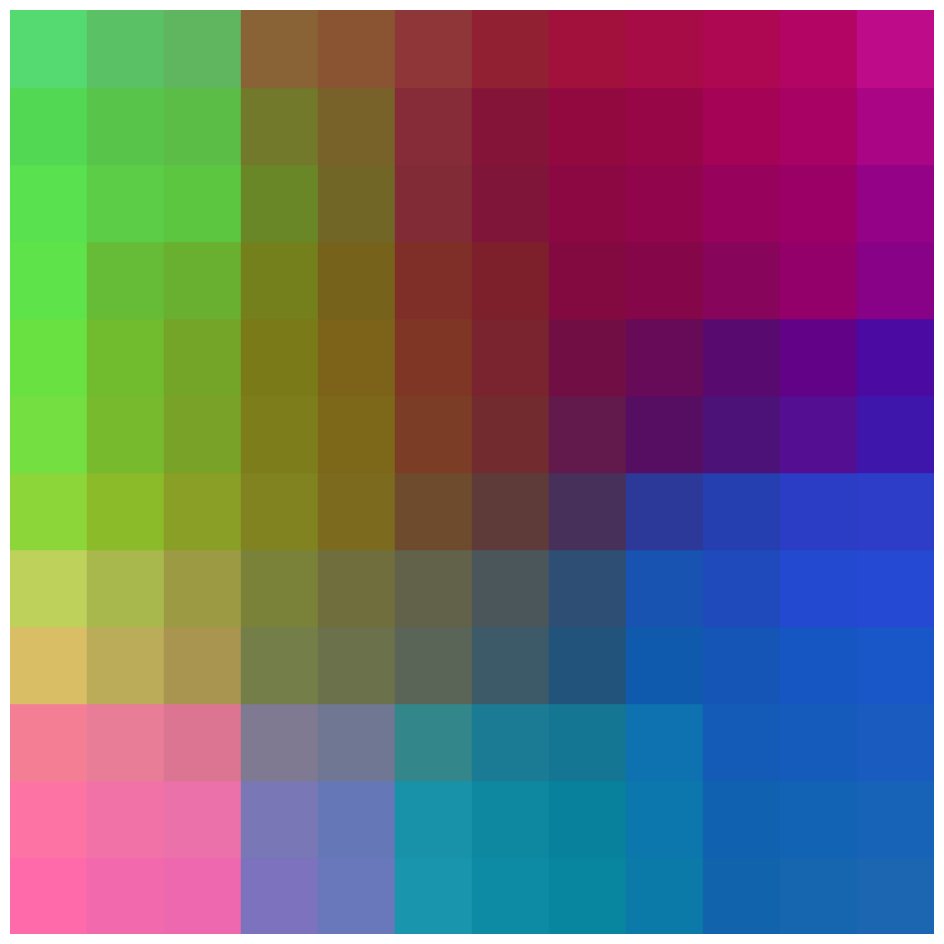

In [13]:
def normalisee(data):
    min_d = np.min(data)
    max_d = np.max(data)
    return (data - min_d) / (max_d - min_d)

# Assume loaded_text_som_model is the trained SOM model
som_height, som_width, vector_dimension = best_som.shape
num_nodes = som_height * som_width

# Assuming sentence_vectors is already defined
pca = PCA(n_components=3)
# Fit PCA on the original high-dimensional sentence vectors
pca.fit(pca_u_matrix)

# Transform the SOM data using the fitted PCA
flattened_som = best_som.reshape(num_nodes, vector_dimension)
colourComponents = pca.transform(flattened_som)

# Normalize the transformed PCA components
normalised_components = normalisee(colourComponents)

# Convert normalized components to RGB values
rgb_values = (normalised_components * 255).astype(np.uint8)

# Prepare a grid for visualization
som_colors = np.zeros((som_height, som_width, 3), dtype=np.uint8)
for i in range(som_height):
    for j in range(som_width):
        node_idx = i * som_width + j
        som_colors[i, j] = rgb_values[node_idx]

# Visualization
fig, ax = plt.subplots(figsize=(som_width, som_height))
for i in range(som_height):
    for j in range(som_width):
        color = som_colors[i, j] / 255.0
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

ax.set_xlim(0, som_width)
ax.set_ylim(0, som_height)
ax.set_aspect('equal')
ax.axis('off')
plt.show()
